In [7]:
# dont ask me, and I won't clean it..
import numpy as np
import glob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
%tensorflow_version 1.x
from PIL import Image
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import plot_model  #plotting the model structure
from keras import callbacks
from datetime import datetime
import os
import cv2
import string
import numpy as np


from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
! wget "https://ndownloader.figshare.com/files/22137672" -O images-1L-processed.tar.gz

--2020-04-28 18:55:27--  https://ndownloader.figshare.com/files/22137672
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.17.144.100, 3.248.161.73, 34.242.129.35, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.17.144.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22137672/images1Lprocessed.tar.gz [following]
--2020-04-28 18:55:28--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22137672/images1Lprocessed.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.104.58
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.104.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225571830 (215M) [application/gzip]
Saving to: ‘images-1L-processed.tar.gz’

images-1L-processed 100%[===================>] 215.12M  11.5MB/s    in 21s     

2020-04-28 18:55:50 (10.4 MB/s) - ‘images-1L-

In [0]:
!tar -xvf images-1L-processed.tar.gz > /dev/null
! echo "Untaring... done..."

Untaring... done...


In [8]:
png_files = glob.glob('images-1L-processed/*.png')
print("Total # of files => ",len(png_files))
png_files[0]

Total # of files =>  109053


'images-1L-processed/6m4r5.png'

In [9]:
symbols = "abcdefghijklmnopqrstuvwxyz" + '0123456789' # These are all symbols the captchas will have
num_symbols = len(symbols)
img = np.array(Image.open(png_files[0]))
shape_ = img.shape
print(shape_, num_symbols)

(50, 200) 36


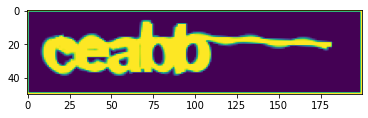

In [10]:
img_path = png_files[1]
img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()

In [0]:
def create_model():
  in_ = Input(shape=img_shape)
  out = in_
  out = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Flatten()(out)
  out = Dropout(0.3)(out)
  out = [Dense(num_symbols, name='digit1', activation='softmax')(out),\
      Dense(num_symbols, name='digit2', activation='softmax')(out),\
      Dense(num_symbols, name='digit3', activation='softmax')(out),\
      Dense(num_symbols, name='digit4', activation='softmax')(out),\
      Dense(num_symbols, name='digit5', activation='softmax')(out)]
  model = Model(inputs=in_, outputs=out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [58]:
from tqdm import tqdm
letters_in_captcha = 5
def preprocess_data():
  n_samples = len(os.listdir('images-1L-processed/'))
  X = np.zeros((n_samples, 200, 50, 1)) #1070*50*200
  print(num_symbols,n_samples)
  y = np.zeros((letters_in_captcha, n_samples, num_symbols)) #5*1070*36
  for i, pic in tqdm(enumerate(os.listdir('images-1L-processed/'))):
    # Read image as grayscale
    img = cv2.imread(os.path.join('images-1L-processed/', pic), cv2.IMREAD_GRAYSCALE)
    #img = cv2.resize(img, (200,50), interpolation = cv2.INTER_AREA)
    pic_target = pic.split('.')[0]
    #print(pic_target)
    
    # plt.imshow(img,cmap='gray')
    # plt.show()
    # break
    # if len(pic_target) < 5:
    # Scale and reshape image
    #print("?")
    img = img / 255.0
    #plt.imshow(img,cmap='gray')
    img = np.reshape(img, (200, 50, 1))
    #img = img[:, :, np.newaxis]
    # Define targets and code them using OneHotEncoding
    targs = np.zeros((letters_in_captcha, num_symbols))
    #print("num symbols = ",num_symbols)
    for j, l in enumerate(pic_target):
      ind = symbols.find(l)
      targs[j, ind] = 1
    X[i] = img
    y[:, i] = targs
    
  # Return final data
  return X, y

X, y = preprocess_data()

0it [00:00, ?it/s]

36 109053


109053it [00:24, 4453.91it/s]


In [0]:
#print(X[0])
print(X[0].shape)
#print(y[0])
print(y[0].shape)

(200, 50, 1)
(109053, 36)


In [0]:
X_train, y_train = X[:90000], y[:, :90000]
X_test, y_test = X[90000:], y[:, 90000:]

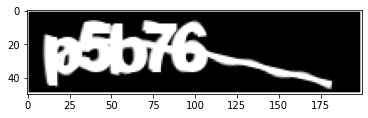

(200, 50, 1)


In [0]:
plt.imshow(X_train[0].reshape((50,200)),cmap='gray')
plt.show()
print(X_train[0].shape)

In [0]:
print(X_train.shape)

(90000, 200, 50, 1)


In [12]:
img_shape = (200, 50, 1)
model=create_model();
model.summary();
# input_3, 
# conv2d_8, conv2d_9, conv2d_10, conv2d_11, conv2d_12, conv2d_13
# batch_normalization_5, max_pooling2d_5, dropout_5, batch_normalization_6, max_pooling2d_6, dropout_6, batch_normalization_7, max_pooling2d_7, dropout_7, batch_normalization_8, max_pooling2d_8 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 50, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 50, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 198, 48, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 48, 32)  128         conv2d_2[0][0]                   
____________________________________________________________________________________________

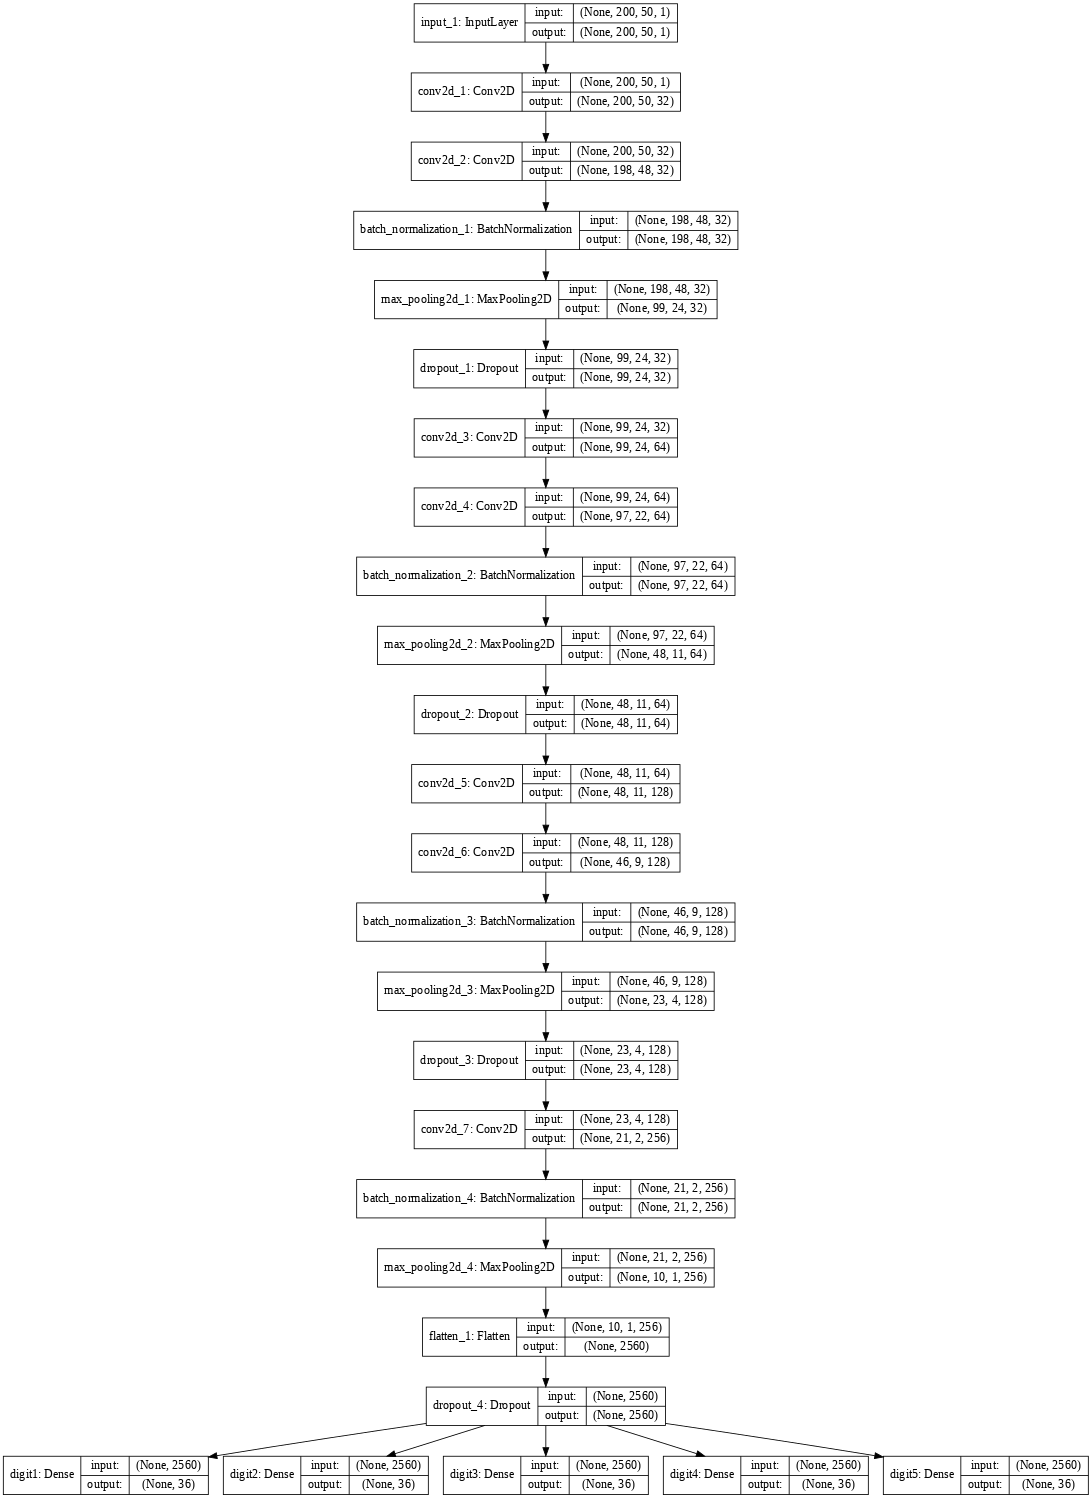

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [0]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2],y_train[3],y_train[4]], batch_size=32, epochs=10,verbose=1, validation_split=0.2,callbacks=[tensorboard_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 81s 1ms/step - loss: 4.7847 - digit1_loss: 0.4275 - digit2_loss: 0.8613 - digit3_loss: 1.0437 - digit4_loss: 1.0455 - digit5_loss: 1.4067 - digit1_acc: 0.8809 - digit2_acc: 0.7450 - digit3_acc: 0.7017 - digit4_acc: 0.7017 - digit5_acc: 0.5985 - val_loss: 0.9870 - val_digit1_loss: 0.0244 - val_digit2_loss: 0.1376 - val_digit3_loss: 0.2166 - val_digit4_loss: 0.3138 - val_digit5_loss: 0.2945 - val_digit1_acc: 0.9921 - val_digit2_acc: 0.9547 - val_digit3_acc: 0.9369 - val_digit4_acc: 0.9101 - val_digit5_acc: 0.9146
Epoch 2/10
72000/72000 [==============================] - 73s 1ms/step - loss: 0.8907 - digit1_loss: 0.0381 - digit2_loss: 0.1468 - digit3_loss: 0.2309 - digit4_loss: 0.2342 - digit5_loss: 0.2406 - digit1_acc: 0.9884 - digit2_acc: 0.9521 - digit3_acc: 0.9307 - digit4_acc: 0.9296

In [0]:
# https://www.tensorflow.org/tensorboard/graphs
%load_ext tensorboard 
%tensorboard --logdir logs

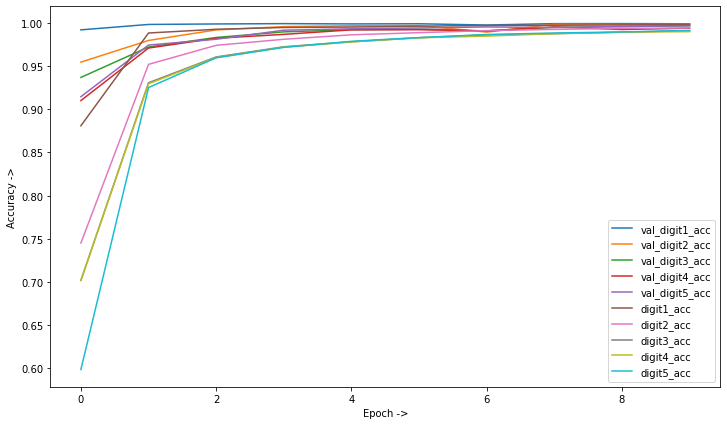

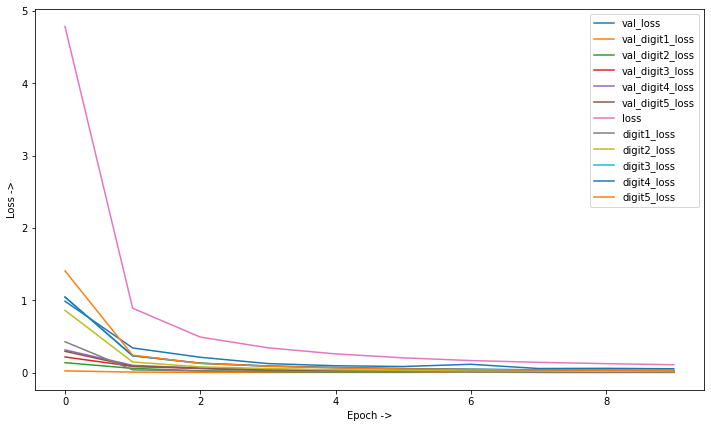

In [0]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='lower right')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [0]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    # # firstly perform erosion
    # erosion = cv2.erode(thresh,kernel,iterations = 1)
    # # perform dialation
    # dialate = cv2.dilate(erosion,kernel,iterations = 1)
    # img = dialate.copy()
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    #res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    new_im = img.reshape((img.shape[1],img.shape[0]))
    res = np.array(model.predict(new_im[np.newaxis,:,:,np.newaxis]))
    #print(res)
    ans = np.reshape(res, (letters_in_captcha, num_symbols))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

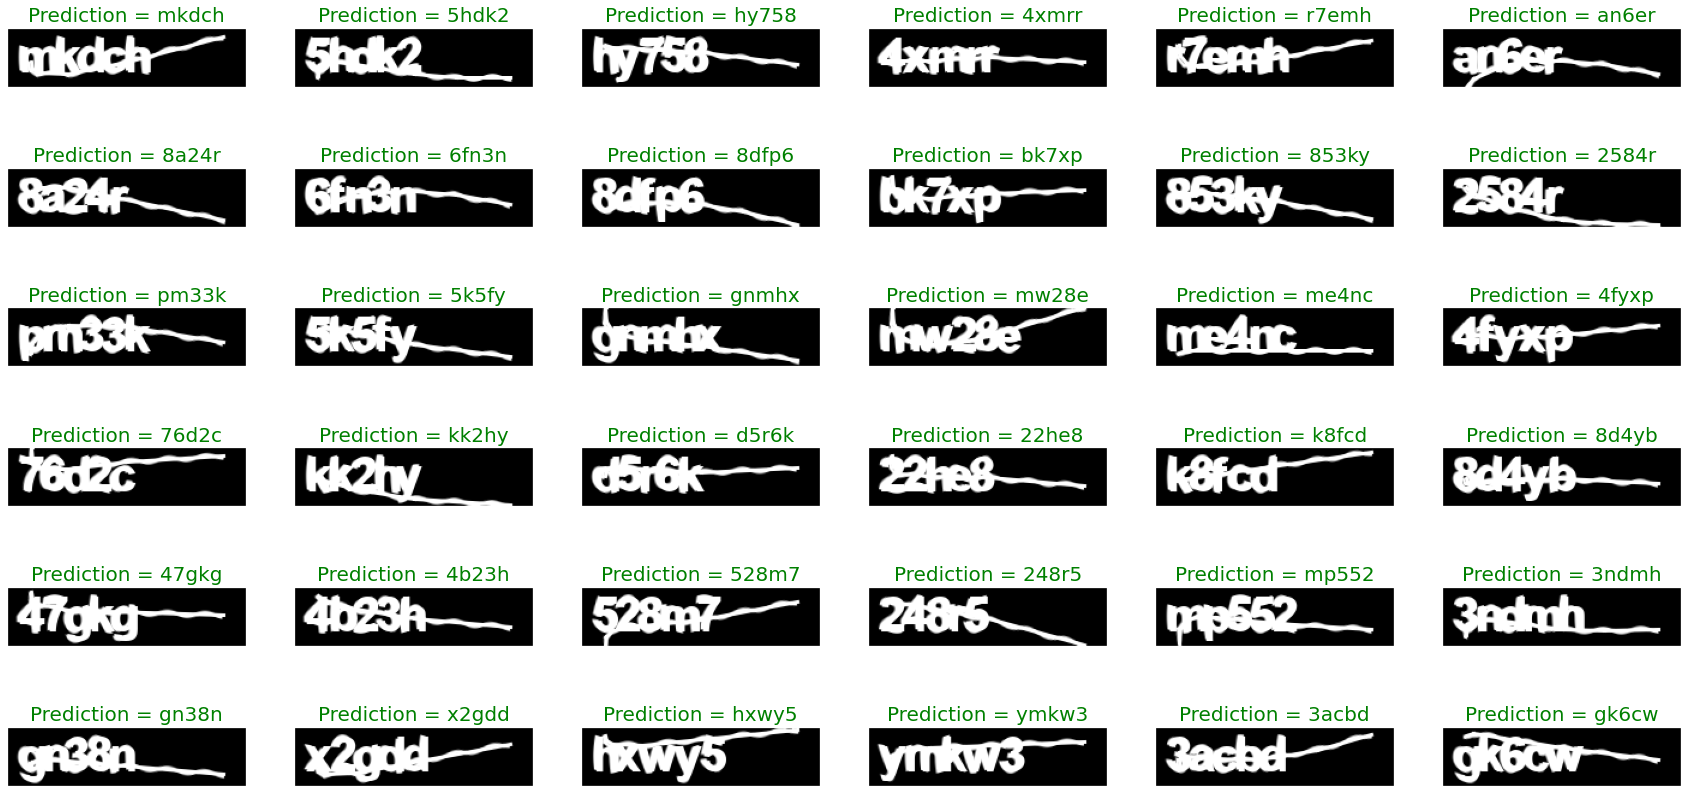

In [0]:
total_img = 36
num_pr = 6 # number per row

counter = 1
plt.figure(figsize=(30,15))
plt.axis('off')
for item in png_files[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  pred = predict(item)
  #print(pred)
  image_bckup = image.copy()
  plt.subplot(num_pr, num_pr, counter)
  #print("item => ",item)
  #print("item => ",str(item.split('_')[1]).split('/')[1])
  if str(item.split('/')[1]).split('.')[0] == str(pred):
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('green')
  else:
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('red')
  plt.axis('off')
  plt.imshow(image_bckup, cmap=plt.get_cmap('gray'))
  counter += 1
  #break
plt.show()

In [0]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2],y_test[3],y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2],y_test[3],y_test[4]])

19053/19053 [==============================] - 21s 1ms/step
Test Loss and accuracy: [0.0557930631086628, 0.0016355428630438588, 0.004289412504027051, 0.016275039294137966, 0.01967182573055072, 0.013921242911073911, 0.9995801186164909, 0.9983204744659634, 0.9946989975331969, 0.9940691754579332, 0.9964310082401722]
19053/19053 [==============================] - 21s 1ms/step


[0.0557930631086628,
 0.0016355428630438588,
 0.004289412504027051,
 0.016275039294137966,
 0.01967182573055072,
 0.013921242911073911,
 0.9995801186164909,
 0.9983204744659634,
 0.9946989975331969,
 0.9940691754579332,
 0.9964310082401722]

In [0]:
# download the model in computer for later use

model.save('images-1L-processed_2.h5')
# download the model from colab
from google.colab import files
files.download('images-1L-processed_2.h5')

In [13]:
load_model('images-1L-processed.h5')

In [61]:
from keras import backend as K

for w in model.trainable_weights:
    #print(K.eval(w))
    print(K.eval(w).shape)
    #plt.imshow(K.eval(w), cmap='viridis')
    #plt.show()


(3, 3, 1, 32)
(32,)
(3, 3, 32, 32)
(32,)
(32,)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(64,)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(128,)
(128,)
(3, 3, 128, 256)
(256,)
(256,)
(256,)
(2560, 36)
(36,)
(2560, 36)
(36,)
(2560, 36)
(36,)
(2560, 36)
(36,)
(2560, 36)
(36,)


32


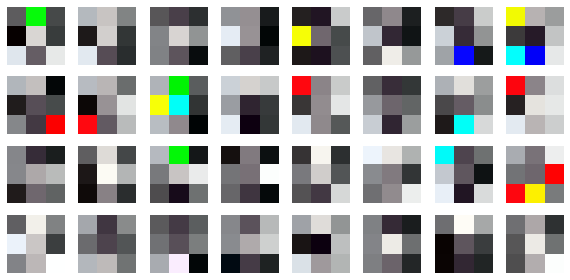

In [14]:
import warnings
warnings.filterwarnings("ignore")
#Select a convolutional layer
layer = model.layers[1]

#Get weights
kernels, biases = layer.get_weights()

#Normalize kernels into [0, 1] range for proper visualization
kernels = (kernels - np.min(kernels, axis=3)) / (np.max(kernels, axis=3) - np.min(kernels, axis=3))

#Weights are usually (width, height, channels, num_filters)
#Save weight images
import cv2
plt.figure(figsize=(10,10))
print(kernels.shape[3])
for i in range(kernels.shape[3]):
    filter = kernels[:, :, :, i]
    #cv2.imwrite('filter-{}.png'.format(i), filter)
    plt.subplot(8, 8, i+1)
    plt.imshow((filter * 255).astype(np.uint8))
    plt.axis('off')
plt.show()

In [0]:
model.trainable_weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32>]

In [16]:
pip install https://github.com/raghakot/keras-vis/archive/master.zip

  Using cached https://github.com/raghakot/keras-vis/archive/master.zip
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=5edf66e4f03099a559d321c62fbb20bd7f45281485189e59956aca1d04bfaf5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zujg8_q/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis


ValueError: ignored

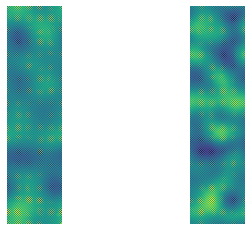

In [18]:
from keras.applications import VGG16
from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter
import matplotlib.pyplot as plt
import numpy as np
import random
import os.path
kount = 1
# Iterate over multiple layers
for layer_nm in ['conv2d_1', 'conv2d_2']:
  #model.add(Dense(no_classes, activation='softmax', name='dense_layer'))
  # Find the particular layer
  layer_idx = utils.find_layer_idx(model, layer_nm)
  # Get the number of filters in this layer
  num_filters = get_num_filters(model.layers[layer_idx])
  # Draw 6 filters randomly
  drawn_filters = random.choices(np.arange(num_filters), k=6)
  # Visualize each filter
  for filter_id in drawn_filters:
    img = visualize_activation(model, layer_idx, filter_indices=filter_id, input_modifiers=[Jitter(16)])
    plt.subplot(1, 2, kount)
    kount += 1
    plt.imshow(img.reshape((200,50)))
    plt.axis('off')
    #plt.show()
    #img_path = os.path.join('.', folder_name, layer_nm + '_' + str(filter_id) + '.jpg')
    #plt.imsave(img_path, img)
    #print(f'Saved layer {layer_nm}/{filter_id} to file!')
plt.show()


In [83]:
kount = 1
for layer_nm in [layer.name for layer in model.layers][1]:
  #model.add(Dense(no_classes, activation='softmax', name='dense_layer'))
  # Find the particular layer
  layer_idx = utils.find_layer_idx(model, layer_nm)
  # Get the number of filters in this layer
  num_filters = get_num_filters(model.layers[layer_idx])
  # Draw 6 filters randomly
  drawn_filters = random.choices(np.arange(num_filters), k=6)
  # Visualize each filter
  for filter_id in drawn_filters:
    img = visualize_activation(model, layer_idx, filter_indices=filter_id, input_modifiers=[Jitter(16)])
    plt.subplot(5, 5, kount)
    kount += 1
    print(kount,"/",ln)
    plt.imshow(img.reshape((200,50)))
    plt.axis('off')
    #img_path = os.path.join('.', folder_name, layer_nm + '_' + str(filter_id) + '.jpg')
    #plt.imsave(img_path, img)
    #print(f'Saved layer {layer_nm}/{filter_id} to file!')
plt.show()

ValueError: ignored

In [77]:
layer_names = [layer.name for layer in model.layers]
len(layer_names)

26

26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26


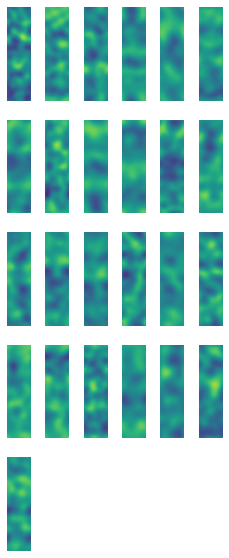

In [24]:
from keras.applications import VGG16
from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter
import matplotlib.pyplot as plt
import numpy as np
import random
import os.path
kount = 1
# Iterate over multiple layers
ln = len([layer.name for layer in model.layers])
print(ln)
plt.figure(figsize=(4,10))
for layer_nm in [layer.name for layer in model.layers]:
  #model.add(Dense(no_classes, activation='softmax', name='dense_layer'))
  # Find the particular layer
  layer_idx = utils.find_layer_idx(model, layer_nm)
  # Get the number of filters in this layer
  num_filters = get_num_filters(model.layers[layer_idx])
  # Draw 6 filters randomly
  drawn_filters = random.choices(np.arange(num_filters), k=6)
  # Visualize each filter
  for filter_id in drawn_filters:
    img = visualize_activation(model, layer_idx, filter_indices=filter_id, input_modifiers=[Jitter(16)])
    if kount == ln:
      break
    plt.subplot(int(ln/5), int(ln/5)+1, kount)
    kount += 1
    print(kount,"/",ln)
    plt.imshow(img.reshape((200,50)))
    plt.axis('off')
    #img_path = os.path.join('.', folder_name, layer_nm + '_' + str(filter_id) + '.jpg')
    #plt.imsave(img_path, img)
    #print(f'Saved layer {layer_nm}/{filter_id} to file!')
  if kount == ln:
      break
plt.show()

In [0]:
import numpy as np
import random
import math
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[0]



img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (200,50), interpolation = cv2.INTER_AREA)
# ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# # firstly perform erosion
# erosion = cv2.erode(thresh,kernel,iterations = 1)
# # perform dialation
# dialate = cv2.dilate(erosion,kernel,iterations = 1)
# img = dialate.copy()

img = img / 255.0
#plt.imshow(img,cmap='gray')
img = np.reshape(img, (200, 50, 1))


x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)



plt.imshow(x.reshape((50,200)), cmap='viridis')

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# #img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
# #img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
# x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
dumy = 0
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    width = 20*20
    height = 8*20
    if dumy < 8*4:
      plt.figure(figsize=(width,height))
    else:
      height = 5
      width = 20
      plt.figure(figsize=(height,width))
    #fig.subplots_adjust(hspace=0.04, wspace=0.04)
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      #ax = fig.add_subplot(int(n_features/4), int(n_features/4), count)
      
      plt.subplot(int(n_features/4), int(n_features/4), count)
      plt.subplots_adjust(hspace = .0001)
      plt.axis("off")
      y = x.copy()
      if dumy<8*4: #4
        plt.imshow(y.reshape((x.shape[1],x.shape[0])), cmap='viridis')
        dumy += 1
      else:
        y = cv2.resize(x, (x.shape[1],x.shape[0]), interpolation = cv2.INTER_AREA)
        plt.imshow(y, cmap='viridis')
      count += 1
  #print(x.shape)
  #break

#plt.show()
print(png_files[0])

In [0]:
import numpy as np
import random
import math
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[0]



img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (200,50), interpolation = cv2.INTER_AREA)
# ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# # firstly perform erosion
# erosion = cv2.erode(thresh,kernel,iterations = 1)
# # perform dialation
# dialate = cv2.dilate(erosion,kernel,iterations = 1)
# img = dialate.copy()

img = img / 255.0
#plt.imshow(img,cmap='gray')
img = np.reshape(img, (200, 50, 1))


x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)



plt.imshow(x.reshape((50,200)), cmap='viridis')

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# #img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
# #img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
# x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
dumy = 0
h1 = 0
w1 = 0
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    width = 20*20
    height = 8*20
    if dumy < 8*4:
      plt.figure(figsize=(width,height))
    else:
      height = 5
      width = 20
      plt.figure(figsize=(height,width))
    #fig.subplots_adjust(hspace=0.04, wspace=0.04)
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      #ax = fig.add_subplot(int(n_features/4), int(n_features/4), count)
      
      plt.subplot(int(n_features/4), int(n_features/4), count)
      plt.subplots_adjust(hspace = .0001)
      plt.axis("off")
      y = x.copy()
      if dumy<8*4: #4
        plt.imshow(y.reshape((x.shape[1],x.shape[0])), cmap='viridis')
        h1 = x.shape[1]
        w1 = x.shape[0]
        dumy += 1
      else:
        y = cv2.resize(x, (h1,w1), interpolation = cv2.INTER_AREA)
        plt.imshow(y, cmap='viridis')
      count += 1
  #print(x.shape)
  #break

#plt.show()
print(png_files[0])

In [0]:
import numpy as np
import random
import math
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[0]



img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (200,50), interpolation = cv2.INTER_AREA)
# ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# # firstly perform erosion
# erosion = cv2.erode(thresh,kernel,iterations = 1)
# # perform dialation
# dialate = cv2.dilate(erosion,kernel,iterations = 1)
# img = dialate.copy()

img = img / 255.0
#plt.imshow(img,cmap='gray')
img = np.reshape(img, (200, 50, 1))


x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)



plt.imshow(x.reshape((50,200)), cmap='viridis')

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# #img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
# #img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
# x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
dumy = 0
h1 = 0
w1 = 0
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    width = 20*20
    height = 8*20
    if dumy < 8*4:
      plt.figure(figsize=(width,height))
    else:
      width = 2*20
      height = 8*20
      plt.figure(figsize=(height,width))
    #fig.subplots_adjust(hspace=0.04, wspace=0.04)
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      #ax = fig.add_subplot(int(n_features/4), int(n_features/4), count)
      
      plt.subplot(int(n_features/4), int(n_features/4), count)
      plt.subplots_adjust(hspace = .0001)
      plt.axis("off")
      y = x.copy()
      if dumy<8*4: #4
        plt.imshow(y.reshape((x.shape[1],x.shape[0])), cmap='viridis')
        h1 = x.shape[1]
        w1 = x.shape[0]
        dumy += 1
      else:
        y = cv2.resize(x, (w1,h1), interpolation = cv2.INTER_AREA)
        plt.imshow(y, cmap='viridis')
      count += 1
  #print(x.shape)
  #break

#plt.show()
print(png_files[0])